In [1]:
import matplotlib.pyplot as plt

from superfv import EulerSolver, plot_1d_slice, OutputLoader
from superfv.initial_conditions import shu_osher

In [2]:
T = 0.178
N = 400

ref_path = "../out/shu-osher-ref"

configs = {
    "ref": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "MM3(1)": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=3,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1,
        NAD_atol=1e-8,
        absolute_dmp=False,
        SED=True,
    ),
    "MM3(0.1)": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=3,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-1,
        NAD_atol=1e-8,
        absolute_dmp=False,
        SED=True,
    ),
    "MM3(0.01)": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=3,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        absolute_dmp=False,
        SED=True,
    ),
}

sims = {}
for name, config in configs.items():
    if name == "ref":
        try:
            sim = OutputLoader(ref_path)
            sims[name] = sim
            continue
        except FileNotFoundError:
            pass

    print(f"Running {name}...")
    sim = EulerSolver(
        ic=shu_osher,
        bcx="free",
        nx=10000 if name == "ref" else N,
        **config,
    )

    try:
        if config.get("MUSCL", False):
            sim.musclhancock(T)
        else:
            sim.run(T, q_max=2)
    except Exception as e:
        print(f"Failed: {e}")
        continue

    sims[name] = sim

Running ref...
Step #10695 @ t=1.78e-01 | dt=4.59e-06 | min(rho)=8.00e-01, min(P)=1.00e+00 | (done)                
Running MUSCL-Hancock...
Step #425 @ t=1.78e-01 | dt=1.98e-05 | min(rho)=8.00e-01, min(P)=1.00e+00 | (done)                  
Running MM3(1)...
Step #430 @ t=1.78e-01 | dt=2.11e-04 | min(rho)=8.00e-01, min(P)=9.63e-01 | (done)                  
Running MM3(0.1)...
Step #424 @ t=1.78e-01 | dt=2.07e-04 | min(rho)=8.00e-01, min(P)=9.48e-01 | (done)                  
Running MM3(0.01)...
Step #424 @ t=1.78e-01 | dt=7.74e-05 | min(rho)=8.00e-01, min(P)=9.76e-01 | (done)                  


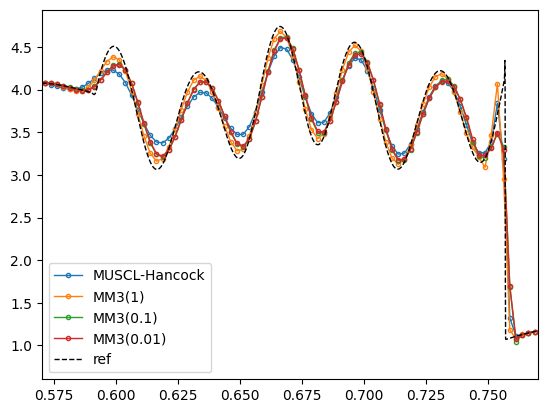

In [3]:
fig, ax = plt.subplots()

ax.set_xlim(0.57, 0.77)

for name, sim in sims.items():
    if name == "ref":
        continue
    plot_1d_slice(
        sim, ax, "rho", label=name, marker="o", mfc="none", linewidth=1, markersize=3
    )

plot_1d_slice(
    sims["ref"], ax, "rho", label="ref", linewidth=1, linestyle="--", color="k"
)

ax.legend()